In [94]:
import sys
sys.path.append(".")
import unittest
import numpy as np
import matplotlib.pyplot as plt

from src.susie.timing_data import TimingData
from src.susie.ephemeris import Ephemeris, PrecessionModelEphemeris
from scipy.optimize import curve_fit
from astropy import time
from astropy import coordinates as coord
from astropy import units as u

test_epochs = np.array([0, 294, 298, 573])
test_mtts = np.array([2454515.525,2454836.403,2454840.769,2455140.91])
test_mtts_err = np.array([0.00043, 0.00028, 0.00062, 0.00042])
test_tra_or_occ = np.array(['tra','occ','tra','occ'])
test_tra_or_occ_enum = [0 if i == 'tra' else 1 for i in test_tra_or_occ]

test_P_fits = 1.091423

test_P_linear =  1.0904734088754364 # period linear
test_P_err_linear =  0.0006807481006299065 # period error linear
test_T0_linear =2454515.423966982# conjunction time
test_T0_err_linear = 0.23692092991744518  # conjunction time error

test_P_quad =  1.0892663209112947#period quad
test_P_err_quad =  0.002368690041166098 # period err quad
test_T0_quad = 2454515.5241231285 #conjunction time quad
test_T0_err_quad = 0.3467430587812461#conjunction time err quad
test_dPdE =  4.223712653342504e-06#period change by epoch
test_dPdE_err = 7.742732700893123e-06#period change by epoch error

test_observed_data = test_mtts
test_uncertainties= test_mtts_err 
 


In [47]:
transit_times_obj1 = TimingData('jd', test_epochs, test_mtts, test_mtts_err, test_tra_or_occ, time_scale='tdb')

In [48]:
transit_times_obj1 = TimingData('jd', test_epochs, test_mtts, test_mtts_err, test_tra_or_occ, time_scale='tdb')
ephemeris_obj1 = Ephemeris(transit_times_obj1)

In [49]:
linear_model_data = ephemeris_obj1.get_model_ephemeris('linear')
linear_model_data

{'period': 1.0904734088754364,
 'period_err': 0.0006807481006299065,
 'conjunction_time': 2454515.423966982,
 'conjunction_time_err': 0.23692092991744518,
 'model_type': 'linear',
 'model_data': array([2454515.42396698, 2454836.5683859 , 2454840.38504283,
        2455140.81046697])}

In [50]:
model_parameters = ephemeris_obj1._get_model_parameters('linear')
model_parameters

{'period': 1.0904734088754364,
 'period_err': 0.0006807481006299065,
 'conjunction_time': 2454515.423966982,
 'conjunction_time_err': 0.23692092991744518}

In [51]:
ephemeris_obj1._get_model_parameters('quadratic')   

{'period': 1.0892663209112947,
 'period_err': 0.002368690041166098,
 'conjunction_time': 2454515.5241231285,
 'conjunction_time_err': 0.3467430587812461,
 'period_change_by_epoch': 4.223712653342504e-06,
 'period_change_by_epoch_err': 7.742732700893123e-06}

In [52]:
def linear_model(test_x, test_P_linear, test_T0_linear):
    """Linear model function."""
    return test_P_linear * test_x + test_T0_linear


popt, pcov = curve_fit(linear_model, test_epochs, test_mtts, sigma=test_mtts_err, absolute_sigma=True)
unc = np.sqrt(np.diag(pcov))
return_data = {
    'period': popt[0],
    'period_err': unc[0],
    'conjunction_time': popt[1],
    'conjunction_time_err': unc[1]
}
return_data

{'period': 1.0914223406835055,
 'period_err': 1.0489630324274194e-06,
 'conjunction_time': 2454515.5249325945,
 'conjunction_time_err': 0.00036467200659212915}

In [53]:
def quad_model(test_epochs, test_dPdE, test_P_quad, test_T0_quad):
    return 0.5*test_dPdE*test_epochs*test_epochs + test_P_quad*test_epochs + test_T0_quad
popt, pcov = curve_fit(quad_model, test_epochs, test_mtts, sigma=test_mtts_err, absolute_sigma=True)
unc = np.sqrt(np.diag(pcov))
return_data = {
            'conjunction_time': popt[2],
            'conjunction_time_err': unc[2],
            'period': popt[1],
            'period_err': unc[1],
            'period_change_by_epoch': popt[0],
            'period_change_by_epoch_err': unc[0],
        }
return_data

{'conjunction_time': 2454515.5249979226,
 'conjunction_time_err': 0.0004299841051609291,
 'period': 1.0914393799928248,
 'period_err': 1.696739076276109e-06,
 'period_change_by_epoch': -8.173424194182869e-08,
 'period_change_by_epoch_err': 2.9002083989492785e-09}

In [54]:
quadratic_model_data = ephemeris_obj1.get_model_ephemeris('quadratic')
quadratic_model_data

{'period': 1.0892663209112947,
 'period_err': 0.002368690041166098,
 'conjunction_time': 2454515.5241231285,
 'conjunction_time_err': 0.3467430587812461,
 'period_change_by_epoch': 4.223712653342504e-06,
 'period_change_by_epoch_err': 7.742732700893123e-06,
 'model_type': 'quadratic',
 'model_data': array([2454515.52412313, 2454836.49559505, 2454840.31302805,
        2455140.91174185])}

In [55]:
##linear fit
P = 1.091423
E = np.array([0, 294, 298, 573])
T0 = 0
tra_or_occ =  np.array([0,1,0,1])
tra = np.round(P * E +T0)
print(tra)
occ = np.round(P * E +(T0+0.5*P))
print(occ)
lin_fit = np.array([0.         , 3.21423879e+02, 325.24385758, 6.25930712e+02 ])
result = np.zeros(len(E))
for i, t_type in enumerate(tra_or_occ):
    if t_type == 0:
                    # transit data
        result[i] = P*E[i] + T0
    elif t_type == 1:
                    # occultation data
        result[i] = P*E[i] + (T0 + 0.5*P)
print(result)

[  0. 321. 325. 625.]
[  1. 321. 326. 626.]
[  0.        321.4240735 325.244054  625.9310905]


In [56]:
##quad fit
P = 1.091423
E =  np.array([0, 294, 298, 573])
T0 = 0
dPdE = 0
tra_q = (0.5*dPdE*E*E + P*E + 0)
print(tra_q)
occ_q = ((0 + 0.5*P) + P*E + 0.5*dPdE*E*E)
print(occ_q)
quad_fit = np.array([0,321,325,626])

[  0.       320.878362 325.244054 625.385379]
[5.45711500e-01 3.21424073e+02 3.25789765e+02 6.25931091e+02]


In [57]:
##linear model uncertainites
T0_err_l =  0.23692091722329203
P_err_l =  0.0006807480614626216
E = test_epochs
tra = (np.sqrt((T0_err_l**2) + ((test_epochs**2)*(P_err_l**2))))
print(tra)
occ = (np.sqrt(((T0_err_l**2) +((test_epochs+0.5)**2) * (P_err_l**2))))
print(occ)
result = np.array([0.23692092,0.31036088, 0.31190525, 0.45667354 ])

[0.23692092 0.31014112 0.31190525 0.45638259]
[0.23692116 0.31036088 0.31212674 0.45667354]


In [58]:
##quad model uncertainite
T0_err_q = test_T0_err_quad
P_err_q = test_P_err_quad
dPdE_err = test_dPdE_err
E = test_epochs
tra = (np.sqrt((T0_err_q**2) + ((E**2)*(P_err_q**2)) + ((1/4)*(E**4)*(dPdE_err**2))))
print(tra)

occ = (np.sqrt( (T0_err_q**2) + (((E+0.5)**2)*(P_err_q**2)) + ((1/4)*(E**4)*(dPdE_err**2))))
print(occ)
result = np.array([0.34674306,0.84783352,0.85829843,1.89241887])


[0.34674306 0.84685934 0.85829843 1.89156889]
[0.34674508 0.84783352 0.8592727  1.89241887]


In [59]:
##calc lin ephem
E = test_epochs
tra = test_T0_linear+test_P_linear*E
print(tra)
occ = (test_T0_linear+0.5*test_P_linear)+(test_P_linear*E)
print(occ)
result = np.array([2454515.42396698, 2454836.5683859, 2454840.38504283, 2455140.81046697])

[2454515.42396698 2454836.02314919 2454840.38504283 2455140.26523027]
[2454515.96920369 2454836.5683859  2454840.93027953 2455140.81046697]


In [60]:
## calc quad ephem
P_q = test_P_quad
T0_q = test_T0_quad
dPdE =  test_dPdE
tra = (T0_q + P_q*E + 0.5*dPdE*E*E)
occ = ((T0_q + 0.5*P_q) + P_q*E + 0.5*dPdE*E*E)
print(tra)
print(occ)
result = np.array([2454515.52412313, 2454836.49559505, 2454840.31302805, 2455140.91174185])

[2454515.52412313 2454835.95096189 2454840.31302805 2455140.36710869]
[2454516.06875629 2454836.49559505 2454840.85766121 2455140.91174185]


In [61]:
#calc chi linear
observed_data = test_mtts
model_data = np.array([2454515.42396698, 2454836.5683859, 2454840.38504283, 2455140.81046697]) 
uncertainties = np.array([0.00043, 0.00028, 0.00062, 0.00042]) 
np.sum(((observed_data - model_data)/uncertainties)**2)

843766.30314325

In [62]:
#calc chi quad
observed_data = test_mtts
model_data = np.array([2454515.52412313, 2454836.49559505, 2454840.31302805, 2455140.91174185])
uncertainties =  np.array([0.00043, 0.00028, 0.00062, 0.00042])
np.sum(((observed_data - model_data)/uncertainties)**2)

650251.5809274575

In [63]:
## calc bic lin
chi_squared= 843766.30314325
num_params=2

chi_squared + (num_params*np.log(4))


843769.0757319723

In [64]:
ephemeris_obj1.get_model_ephemeris('linear')

{'period': 1.0904734088754364,
 'period_err': 0.0006807481006299065,
 'conjunction_time': 2454515.423966982,
 'conjunction_time_err': 0.23692092991744518,
 'model_type': 'linear',
 'model_data': array([2454515.42396698, 2454836.5683859 , 2454840.38504283,
        2455140.81046697])}

In [65]:
ephemeris_obj1.get_model_ephemeris('quadratic')

{'period': 1.0892663209112947,
 'period_err': 0.002368690041166098,
 'conjunction_time': 2454515.5241231285,
 'conjunction_time_err': 0.3467430587812461,
 'period_change_by_epoch': 4.223712653342504e-06,
 'period_change_by_epoch_err': 7.742732700893123e-06,
 'model_type': 'quadratic',
 'model_data': array([2454515.52412313, 2454836.49559505, 2454840.31302805,
        2455140.91174185])}

In [66]:
## calc bic quad
chi_squared= 650251.5809274575
num_params=3

chi_squared + (num_params*np.log(4))

650255.7398105409

In [67]:
linear_bic =  843769.0757319723
quadratic_bic =  650255.7398105409
linear_bic - quadratic_bic

193513.33592143143

In [68]:
from astropy.time import Time, TimeDelta

# Example mid_times data
mid_times = ['2024-05-23T12:34:56', '2024-05-24T12:34:56']
time_format = 'isot'  # ISO 8601 format
time_scale = 'utc'    # Coordinated Universal Time scale

mid_times_obj = Time(mid_times, format=time_format, scale=time_scale)
mid_times_obj

<Time object: scale='utc' format='isot' value=['2024-05-23T12:34:56.000' '2024-05-24T12:34:56.000']>

In [69]:
test_mid_times = ['2024-05-23T12:34:56', '2024-05-24T12:34:56']
test_time_format = 'isot'  
test_time_scale = 'utc' 

# Create the Time object
mid_times_obj = Time(mid_times, format=time_format, scale=time_scale)

# Output the Time object and its attributes
print(mid_times_obj)
print("Julian Date:", mid_times_obj.jd)
print("Barycentric Dynamical Time:", mid_times_obj.tdb)

['2024-05-23T12:34:56.000' '2024-05-24T12:34:56.000']
Julian Date: [2460454.02425926 2460455.02425926]
Barycentric Dynamical Time: ['2024-05-23T12:36:05.185' '2024-05-24T12:36:05.185']


In [70]:
test_mid_times_uncertainties = ['0.1', '0.2']
test_time_format = 'jd'  
test_time_scale = 'tdb' 
test_mid_times_uncertainties_obj = TimeDelta(test_mid_times_uncertainties, format=test_time_format, scale=test_time_scale)
print(test_mid_times_uncertainties_obj)
print("Julian Date:", test_mid_times_uncertainties_obj.jd)
print("Barycentric Dynamical Time:", test_mid_times_uncertainties_obj.tdb)

[0.1 0.2]
Julian Date: [0.1 0.2]
Barycentric Dynamical Time: [0.1 0.2]


In [71]:
from astropy.time import TimeDelta

# Example uncertainties data
mid_time_uncertainties = ['0.1', '0.2']  # Uncertainties in seconds
time_format = 'jd'  
time_scale = 'tdb' 

# Convert uncertainties to floating-point numbers and seconds
mid_time_uncertainties = [float(uncertainty) for uncertainty in mid_time_uncertainties]

# Create the TimeDelta object representing uncertainties
mid_time_uncertainties_obj = TimeDelta(mid_time_uncertainties, format=time_format, scale=time_scale)

# Output the TimeDelta object and its attributes
print(mid_time_uncertainties_obj)

[0.1 0.2]


In [72]:
from astropy.time import Time

# Define the time value in BJD-UTC
time_bjd_utc = 2457585.914587

# Create a Time object with the BJD-UTC value
time_obj = Time(time_bjd_utc, format='jd', scale='utc')

# Convert the time value to BJD-TDB
time_bjd_tdb = time_obj.tdb.jd

# Output the converted value
print("BJD-TDB:", time_bjd_tdb)

BJD-TDB: 2457585.9153761626


In [73]:
mid_times = np.array([2457585.914587, 2457586.914587])  # An array of float times
time_format = 'jd'  # Julian Date format
time_scale = 'tdb'  # Coordinated Universal Time scale

# Create the Time object
mid_times_obj = Time(mid_times, format=time_format, scale=time_scale)

# Output the Time object and its attributes
print(mid_times_obj)
# print("Julian Date:", mid_times_obj.jd)
# print("Barycentric Dynamical Time:", mid_times_obj.tdb)

[2457585.914587 2457586.914587]


In [74]:
object_ra = 150.0  # Right ascension in degrees
object_dec = 2.5   # Declination in degrees
obj_coords = (object_ra, object_dec)
print("\nObject coordinates (RA, DEC):")
print(obj_coords)

# Observatory coordinates (Longitude, Latitude)
observatory_lon = -70.0  # Longitude in degrees
observatory_lat = -30.0  # Latitude in degrees
obs_coords = (observatory_lon, observatory_lat)
print("\nObservatory coordinates (Longitude, Latitude):")
print(obs_coords)


Object coordinates (RA, DEC):
(150.0, 2.5)

Observatory coordinates (Longitude, Latitude):
(-70.0, -30.0)


In [75]:
import numpy as np
from astropy.time import Time

# # Example mid-transit times (Julian Dates)
# mid_times = np.array([2457585.914587, 2457586.914587])

# # Create the Time object with Julian Date format and Barycentric Dynamical Time scale
# test_mid_times_obj = Time(mid_times, scale='tdb')

# # Print the mid-transit times object
# print("Mid-transit times (JD, TDB):")
# print(test_mid_times_obj)

In [76]:

# time_mtts = time.Time(test_mtts, format='jd', scale='tdb')
# time_mtts_err = time.Time(test_mtts_err, format='jd', scale='tdb')  

# converted_mtts = time_mtts.to_value( 'utc','isot')
# converted_mtts_err = time_mtts_err.to_value( 'utc','isot')

In [77]:
timing_data = TimingData('jd', test_epochs, test_mtts, test_mtts_err, time_scale='utc', object_ra=97.64, object_dec=29.67, observatory_lat=43.60, observatory_lon= -116.21)

In [78]:
# test_epochs = np.array([0, 294, 298, 573])
# test_mtts = np.array([0.0, 320.8780000000261, 325.24399999994785, 625.3850000002421])
# timing_data = TimingData('jd', test_epochs, test_mtts, test_mtts_err, object_ra=97.64, object_dec=29.67, observatory_lat=43.60, observatory_lon=-116.21)
# time_obj = time.Time(test_mtts,format = 'jd',scale = 'utc')
# obj_location = coord.SkyCoord(ra = 97.6,dec = 29.67, unit = 'deg')
# obs_location = coord.EarthLocation(lat = 43.60, lon = -116.21)
# expected_result = np.array([3.11451337e-03,3.20883762e+02,3.25249628e+02,6.25389263e+02])
# actual_result = timing_data._calc_barycentric_time(time_obj, obj_location, obs_location)
# print(actual_result)

In [79]:
# test_time_obj = time.Time(test_mtts, format='jd', scale='utc')
# time_obj = test_time_obj
# time_obj.location = obs_location
# ltt_bary = time_obj.light_travel_time(obj_location)
# print(ltt_bary)

In [80]:
expected_obs_location = coord.EarthLocation.from_geodetic( -116.21,43.61)
expected_obs_location

<EarthLocation (-2042896.91935218, -4149886.23746303, 4376818.76798957) m>

In [81]:
test_mtts =  np.array([2454515.42396698, 2454836.5683859 , 2454840.38504283, 2455140.81046697])
transits = test_mtts-test_T0_linear-(test_P_linear*test_epochs)
occultations = test_mtts-test_T0_linear-(0.5*test_P_linear)-(test_P_linear*test_epochs)
print(transits)
print(occultations)
np.array([-1.86264515e-09, 4.24597602e-09, 3.08841663e-09 , -2.14754436e-09])

[-1.86264515e-09  5.45236709e-01  3.08841663e-09  5.45236702e-01]
[-5.45236706e-01  4.24597602e-09 -5.45236701e-01 -2.14754436e-09]


array([-1.86264515e-09,  4.24597602e-09,  3.08841663e-09, -2.14754436e-09])

In [82]:
def transit_full(self,P,R_star,a,R_planet,b,i):
    k = R_planet/R_star
    transit = (P/np.pi)*np.arcsin((((R_star/a)*(((1-k)**2)-(b**2)))**1/2)/np.sin(i))
    return transit

In [83]:
timing_data = TimingData('jd', test_epochs, test_mtts, test_mtts_err, test_tra_or_occ, 'utc', object_ra=97.64, object_dec=29.67, observatory_lat=43.60, observatory_lon=-116.21)
obs_location = coord.EarthLocation(lat = 43.60, lon = -116.21)
time_obj = time.Time(test_mtts_err, format='jd', scale='utc', location=obs_location)
obj_location = coord.SkyCoord(ra = 97.6,dec = 29.67, unit = 'deg')
obs_location = coord.EarthLocation(lat = 43.60, lon = 116.21)
timing_data._calc_barycentric_time(time_obj,obj_location)

/Users/adriennekirk/Desktop/susie/.venv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 4 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/adriennekirk/Desktop/susie/.venv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 4 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/adriennekirk/Desktop/susie/.venv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 4 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/adriennekirk/Desktop/susie/.venv/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "epv00" yielded 4 of "warning: date outsidethe range 1900-2100 AD"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


array([0.00354448, 0.00339449, 0.00373446, 0.00353448])

In [84]:
timing_data._convert_timing_uncertainties(test_mtts, test_mtts_err, 'jd', 'tdb', obj_coords, obs_coords)


array([0.00060812, 0.00039601, 0.00087687, 0.00059403])

In [85]:
anomalistic_period = 3.0
pericenter = np.array([0.01,0.02,0.03,0.04])
e = 0.004


T0 + anomalistic_period/2 + E*P + ((e*anomalistic_period)/np.pi)*np.cos(pericenter)

array([  1.50381953, 322.38218095, 326.747872  , 626.88919566])

In [102]:
test_epochs_precession = np.array([ -1640, -1346,  -1342, -1067, -1061, -1046,  -1038])
test_mtts_precession = np.array([2454515.525,2454836.403,2454840.769,2455140.91, 2455147.459, 2455163.831,2455172.561])
test_mtts_err_precession = np.array([0.00043, 0.00028, 0.00062, 0.00042, 0.00043, 0.00032, 0.00036])
test_tra_or_occ_precession = np.array(['tra','occ','occ','tra', 'tra', 'tra', 'tra'])
test_tra_or_occ_enum_precession = [0 if i == 'tra' else 1 for i in test_tra_or_occ_precession]
transit_times_obj1_precession = TimingData('jd', test_epochs_precession, test_mtts_precession, test_mtts_err_precession, test_tra_or_occ_precession, time_scale='tdb')
ephemeris_obj1 = Ephemeris(transit_times_obj1_precession)
precession_model_data = ephemeris_obj1._get_model_parameters('precession')
precession_model_data

{'period': 1.0914233780823739,
 'period_err': 2.5837552101593316e-06,
 'conjunction_time': 2454515.5247473116,
 'conjunction_time_err': 0.0016189004920040013,
 'eccentricity': 0.5345414535549522,
 'eccentricity_err': 13588.186664524692,
 'pericenter': -55020653.47561098,
 'pericenter_err': 589049.1819169023,
 'pericenter_change_by_epoch': -862310.36579702,
 'pericenter_change_by_epoch_err': 1933.7369753292073}

In [87]:
test_P_fits = 1.091423
dwdE =  0.000984
e =  0.00310
W0 =  2.62
PA = P/(1 - (1/(2*np.pi))*dwdE)
print(PA)
w = W0 + dwdE*test_epochs_precession
print(w)


1.0915939528522707
[2.62     2.909296 2.913232 3.183832 3.189736 3.204496 3.212368]


In [88]:
test_PA = 1.0915939528522707
# test_w = np.array([2.62, 2.909296, 2.913232, 2.9152, 2.95456, 2.9644, 2.97424])
test_w = np.array([1.00624,  1.295536, 1.299472, 1.570072, 1.575976, 1.590736, 1.598608])

tra =  T0 + test_epochs_precession*test_P_fits - ((e*test_PA)/np.pi)*np.cos(test_w)
occ = T0 + test_PA/2 + test_epochs_precession*test_P_fits + ((e*test_PA)/np.pi)*np.cos(test_w)
print(tra)
print(occ)
# test_precession_fit = np.array([9.33910858e-04, 3.21423111e+02, 3.25788802e+02, 6.25386429e+02,6.31934975e+02, 6.48306322e+02, 6.57037708e+02])
test_precession_fit = np.array([-5.76315154e-04, 3.21424452e+02, 3.25790140e+02, 6.25385378e+02, 6.31933923e+02,  6.48305283e+02,  6.57036676e+02])

[-5.76315154e-04  3.20878069e+02  3.25243765e+02  6.25385378e+02
  6.31933923e+02  6.48305283e+02  6.57036676e+02]
[5.46373292e-01 3.21424452e+02 3.25790140e+02 6.25931177e+02
 6.32479708e+02 6.48851037e+02 6.57582413e+02]


In [101]:
test_W0 = 2.62
test_dwdE = 0.000984
test_e = 0.00310
test_PA = 1.0915939528522707
test_epochs_precession = np.array([ -1640, -1346,  -1342, -1067, -1061, -1046,  -1038])
test_tra_or_occ_precession = np.array(['tra','occ','occ','tra', 'tra', 'tra', 'tra'])
test_W = np.array([1.00624,  1.295536, 1.299472, 1.570072, 1.575976, 1.590736, 1.598608])
result_tra = 0 + test_epochs_precession*test_P_fits - ((test_e*test_PA)/np.pi)*np.cos(test_W)
result_occ = 0 + test_PA/2 + test_epochs_precession*test_P_fits + ((test_e*test_PA)/np.pi)*np.cos(test_W)
print(result_tra)
print(result_occ)

[-1789.93429632 -1469.05565076 -1464.68995468 -1164.54834178
 -1157.99979742 -1141.62843652 -1132.89704405]
[-1789.38734671 -1468.50926826 -1464.14358034 -1164.00254324
 -1157.4540116  -1141.0826825  -1132.35130698]


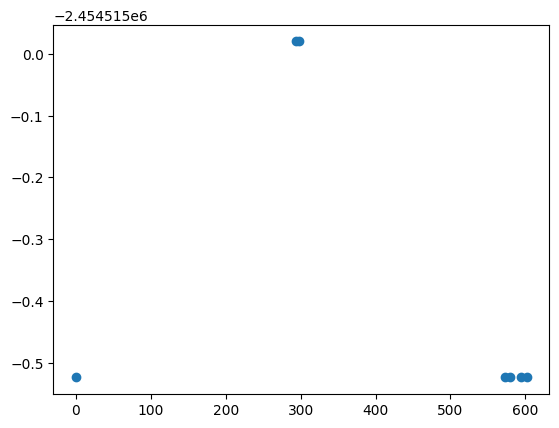

In [100]:
precession_obj = PrecessionModelEphemeris()
prec_transit_times = precession_obj.precession_fit(test_epochs_precession, 0, test_P_fits, test_dwdE, test_W0, test_e, test_tra_or_occ_enum_precession)
plt.scatter(test_epochs_precession, (prec_transit_times - 2454515.5247473116 - 1.0914233780823739 * test_epochs_precession))

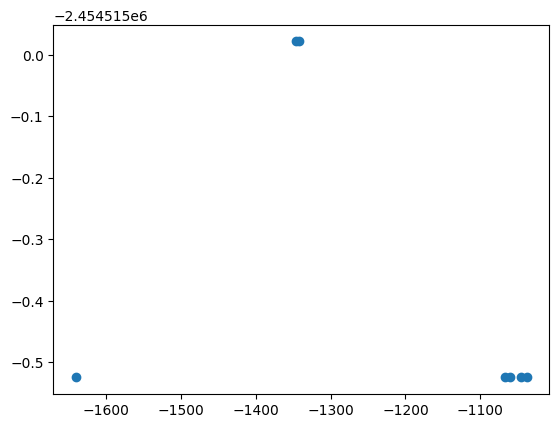

In [91]:
prec_transit_times = np.array([-1789.93429632, -1468.50926826, -1464.14358034, -1164.54834178, -1157.99979742, -1141.62843652, -1132.89704405])
plt.scatter(test_epochs_precession, (prec_transit_times - 2454515.5247473116 - 1.0914233780823739 * test_epochs_precession))
